# Analisi del Paradosso del Momentum: Performance Diverse tra Strategie

## Obiettivo
Questo notebook analizza perché ci sono differenze drammatiche nelle performance tra:
1. **Strategia Momentum solo Commodities (long-only)**: Performance deludenti
2. **Strategia Forex+Commodities (long/short)** del notebook principale: Performance eccellenti  
3. **Subset pre-selezionato di commodities**: Performance moderate

## Ipotesi da testare:
1. **Strategia Long/Short vs Long-Only**: la possibilità di andare short migliora drasticamente le performance
2. **Forex + Commodities vs Solo Commodities**: l'aggiunta del forex offre migliori opportunità di momentum
3. **Diluizione del segnale**: troppi asset nel solo momentum commodities
4. **Qualità del momentum**: alcuni asset hanno momentum più persistente di altri
5. **Correlazione incrociata**: forex e commodities si completano a vicenda
6. **Market regimes**: diversi periodi favoriscono diversi tipi di asset

## 1. Setup e Caricamento Dati

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configurazione per visualizzazioni migliori
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1200)

In [37]:
# Carica i dati delle commodities E forex per replicare la strategia del main notebook
df_commodities = pd.read_parquet('../data/commodities_extended_data.parquet')
df_forex = pd.read_parquet('../data/forex_synchronized_data.parquet')

print(f'📊 DATI COMMODITIES:')
print(f'Range temporale: {df_commodities.index.min()} -> {df_commodities.index.max()}')
print(f'Numero di osservazioni: {len(df_commodities)}')

print(f'\n📊 DATI FOREX:')
print(f'Range temporale: {df_forex.index.min()} -> {df_forex.index.max()}')
print(f'Numero di osservazioni: {len(df_forex)}')

# Rimuovi timezone dai dati commodities per compatibilità
df_commodities.index = df_commodities.index.tz_localize(None)

# Converte l'indice forex a timezone naive per compatibilità
df_forex.index = df_forex.index.tz_localize(None)

# Estrai tutte le commodities disponibili
all_commodities = sorted(set([c.replace('_Close', '') for c in df_commodities.columns if c.endswith('_Close')]))
print(f'\nTutte le commodities ({len(all_commodities)}): {all_commodities}')

# Estrai coppie forex disponibili  
all_forex = sorted(set([c.replace('_Close', '') for c in df_forex.columns if c.endswith('_Close')]))
print(f'\nTutte le coppie forex ({len(all_forex)}): {all_forex}')

# Combina i dataset per l'analisi (intersezione temporale)
common_dates = df_commodities.index.intersection(df_forex.index)
print(f'\nDate comuni: {len(common_dates)} osservazioni ({common_dates.min()} -> {common_dates.max()})')

if len(common_dates) > 0:
    # Crea dataset combinato
    df_combined = pd.concat([
        df_commodities.loc[common_dates],
        df_forex.loc[common_dates]
    ], axis=1)
    
    print(f'\nDataset combinato: {df_combined.shape[0]} righe x {df_combined.shape[1]} colonne')
else:
    print('\n⚠️ Nessuna data comune tra forex e commodities - analisi limitata solo a commodities')
    df_combined = df_commodities

# Subset vincente commodities-only per confronto
winner_subset = ['GOLD', 'SILVER', 'CRUDE_WTI', 'NATGAS']  
print(f'\nSubset "vincente" commodities (4): {winner_subset}')

# Verifica che esistano nel dataset
missing_commodities = [c for c in winner_subset if f'{c}_Close' not in df_commodities.columns]
if missing_commodities:
    print(f'⚠️ Commodities mancanti: {missing_commodities}')
else:
    print('✅ Tutte le commodities del subset sono disponibili')

# Assegna df per compatibilità con celle successive
df = df_commodities

📊 DATI COMMODITIES:
Range temporale: 2000-01-03 00:00:00-05:00 -> 2025-08-04 00:00:00-04:00
Numero di osservazioni: 6452

📊 DATI FOREX:
Range temporale: 2010-01-01 00:00:00 -> 2025-08-01 00:00:00
Numero di osservazioni: 4066

Tutte le commodities (27): ['COCOA', 'COFFEE', 'COPPER', 'CORN', 'COTTON', 'CRUDE_BRENT', 'CRUDE_WTI', 'FEEDER_CATTLE', 'GASOLINE', 'GOLD', 'HEATING_OIL', 'LEAN_HOGS', 'LIVE_CATTLE', 'LUMBER', 'NATGAS', 'OATS', 'ORANGE_JUICE', 'PALLADIUM', 'PLATINUM', 'ROUGH_RICE', 'RUSSELL_2000_MINI', 'SILVER', 'SOYBEANS', 'SOYMEAL', 'SOYOIL', 'SUGAR', 'WHEAT']

Tutte le coppie forex (22): ['AUDCAD', 'AUDCHF', 'AUDJPY', 'AUDNZD', 'AUDUSD', 'EURAUD', 'EURCAD', 'EURCHF', 'EURGBP', 'EURJPY', 'EURNZD', 'EURUSD', 'GBPAUD', 'GBPCAD', 'GBPCHF', 'GBPJPY', 'GBPUSD', 'NZDJPY', 'NZDUSD', 'USDCAD', 'USDCHF', 'USDJPY']

Date comuni: 3920 osservazioni (2010-01-04 00:00:00 -> 2025-08-01 00:00:00)

Dataset combinato: 3920 righe x 277 colonne

Subset "vincente" commodities (4): ['GOLD', 'SILVER',

## 2. Implementazione Strategia per Confronto

In [39]:
def calculate_momentum_strategy(df, commodities_list, lookback_days=90, top_n=3, rebalance_weekday=4):
    """
    Implementa strategia momentum LONG-ONLY per una lista specifica di commodities
    """
    # Filtra solo le colonne delle commodities specificate
    close_cols = [f'{c}_Close' for c in commodities_list if f'{c}_Close' in df.columns]
    prices = df[close_cols].copy()
    
    # Calcola rendimenti momentum
    momentum = prices.pct_change(lookback_days).fillna(0)
    
    # Crea segnali di peso
    signals = pd.DataFrame(0.0, index=df.index, columns=[f'{c}_weight' for c in commodities_list])
    
    # Giorni di ribilanciamento
    rebalance_dates = df.index[df.index.weekday == rebalance_weekday]
    
    for date in rebalance_dates:
        if date not in momentum.index:
            continue
            
        # Calcola momentum per questo giorno
        mom_values = momentum.loc[date]
        mom_values = mom_values[mom_values > 0]  # Solo momentum positivo
        
        if len(mom_values) > 0:
            # Seleziona top N con momentum più alto
            selected = mom_values.nlargest(min(top_n, len(mom_values)))
            
            # Assegna peso uguale (strategia equi-pesata)
            weight = 1.0 / len(selected)
            
            # Applica pesi dal prossimo giorno di trading
            future_dates = df.index[df.index > date]
            if len(future_dates) > 0:
                next_rebalance = rebalance_dates[rebalance_dates > date]
                end_date = next_rebalance[0] if len(next_rebalance) > 0 else df.index[-1]
                
                period_dates = df.index[(df.index > date) & (df.index <= end_date)]
                
                for asset in selected.index:
                    asset_name = asset.replace('_Close', '')
                    weight_col = f'{asset_name}_weight'
                    if weight_col in signals.columns:
                        signals.loc[period_dates, weight_col] = weight
    
    # Calcola performance del portafoglio
    portfolio_returns = pd.Series(0.0, index=df.index)
    
    for i in range(1, len(df)):
        date = df.index[i]
        prev_date = df.index[i-1]
        
        daily_return = 0.0
        for commodity in commodities_list:
            weight_col = f'{commodity}_weight'
            price_col = f'{commodity}_Close'
            
            if weight_col in signals.columns and price_col in df.columns:
                weight = signals.loc[prev_date, weight_col]
                if weight > 0 and not pd.isna(df.loc[date, price_col]) and not pd.isna(df.loc[prev_date, price_col]):
                    asset_return = (df.loc[date, price_col] / df.loc[prev_date, price_col]) - 1
                    daily_return += weight * asset_return
        
        portfolio_returns.loc[date] = daily_return
    
    # Calcola equity curve
    equity = (1 + portfolio_returns).cumprod()
    
    return signals, equity, portfolio_returns


def calculate_longshort_momentum_strategy(df, assets_list, lookback_days=90, top_n=5, rebalance_weekday=4):
    """
    Implementa strategia momentum LONG/SHORT per forex + commodities (replica del main notebook)
    """
    # Filtra solo le colonne degli assets specificati
    close_cols = [f'{a}_Close' for a in assets_list if f'{a}_Close' in df.columns]
    prices = df[close_cols].copy()
    
    # Calcola rendimenti momentum
    momentum = prices.pct_change(lookback_days).fillna(0)
    
    # Crea segnali di peso
    signals = pd.DataFrame(0.0, index=df.index, columns=[f'{a}_weight' for a in assets_list])
    
    # Giorni di ribilanciamento
    rebalance_dates = df.index[df.index.weekday == rebalance_weekday]
    
    for date in rebalance_dates:
        if date not in momentum.index:
            continue
            
        # Calcola momentum per questo giorno
        mom_values = momentum.loc[date].dropna()
        
        if len(mom_values) >= 2:  # Serve almeno 2 asset per long/short
            # Top N con momentum più alto (LONG)
            top_long = mom_values.nlargest(top_n)
            # Top N con momentum più basso (SHORT)
            top_short = mom_values.nsmallest(top_n)
            
            # Peso uguale per long e short
            long_weight = 1.0 / len(top_long) if len(top_long) > 0 else 0
            short_weight = -1.0 / len(top_short) if len(top_short) > 0 else 0
            
            # Applica pesi dal prossimo giorno di trading
            future_dates = df.index[df.index > date]
            if len(future_dates) > 0:
                next_rebalance = rebalance_dates[rebalance_dates > date]
                end_date = next_rebalance[0] if len(next_rebalance) > 0 else df.index[-1]
                
                period_dates = df.index[(df.index > date) & (df.index <= end_date)]
                
                # Assegna pesi LONG
                for asset in top_long.index:
                    asset_name = asset.replace('_Close', '')
                    weight_col = f'{asset_name}_weight'
                    if weight_col in signals.columns:
                        signals.loc[period_dates, weight_col] = long_weight
                
                # Assegna pesi SHORT
                for asset in top_short.index:
                    asset_name = asset.replace('_Close', '')
                    weight_col = f'{asset_name}_weight'
                    if weight_col in signals.columns:
                        signals.loc[period_dates, weight_col] = short_weight
    
    # Calcola performance del portafoglio
    portfolio_returns = pd.Series(0.0, index=df.index)
    
    for i in range(1, len(df)):
        date = df.index[i]
        prev_date = df.index[i-1]
        
        daily_return = 0.0
        for asset in assets_list:
            weight_col = f'{asset}_weight'
            price_col = f'{asset}_Close'
            
            if weight_col in signals.columns and price_col in df.columns:
                weight = signals.loc[prev_date, weight_col]
                if weight != 0 and not pd.isna(df.loc[date, price_col]) and not pd.isna(df.loc[prev_date, price_col]):
                    asset_return = (df.loc[date, price_col] / df.loc[prev_date, price_col]) - 1
                    daily_return += weight * asset_return
        
        portfolio_returns.loc[date] = daily_return
    
    # Calcola equity curve
    equity = (1 + portfolio_returns).cumprod()
    
    return signals, equity, portfolio_returns

## 3. Confronto Performance: 3 Strategie Diverse

Ora confrontiamo le tre strategie principali:
1. **Solo Commodities (long-only)**: Strategia tradizionale momentum su commodities
2. **Subset Commodities (long-only)**: 4 migliori commodities selezionate
3. **Forex+Commodities (long/short)**: Strategia del notebook principale

In [40]:
# Strategia 1: Solo commodities (long-only)
print("🔄 Calcolando strategia su COMMODITIES ONLY (long-only)...")
signals_commodities, equity_commodities, returns_commodities = calculate_momentum_strategy(
    df, all_commodities, lookback_days=90, top_n=3
)

# Strategia 2: Subset vincente commodities (long-only)
print("🔄 Calcolando strategia su SUBSET vincente (long-only)...")
signals_subset, equity_subset, returns_subset = calculate_momentum_strategy(
    df, winner_subset, lookback_days=90, top_n=3
)

# Strategia 3: Forex + Commodities (long/short) - replica del main notebook
print("🔄 Calcolando strategia FOREX+COMMODITIES (long/short)...")
signals_longshort, equity_longshort, returns_longshort = calculate_longshort_momentum_strategy(
    df_combined, all_forex + all_commodities, lookback_days=90, top_n=5
)

print("✅ Calcoli completati per tutte e 3 le strategie!")

🔄 Calcolando strategia su COMMODITIES ONLY (long-only)...
🔄 Calcolando strategia su SUBSET vincente (long-only)...
🔄 Calcolando strategia su SUBSET vincente (long-only)...
🔄 Calcolando strategia FOREX+COMMODITIES (long/short)...
🔄 Calcolando strategia FOREX+COMMODITIES (long/short)...
✅ Calcoli completati per tutte e 3 le strategie!
✅ Calcoli completati per tutte e 3 le strategie!


In [41]:
# Confronto statistiche performance per TUTTE E 3 le strategie
def calculate_performance_stats(equity, returns):
    total_return = (equity.iloc[-1] - 1) * 100
    annualized_return = ((equity.iloc[-1] ** (252 / len(equity))) - 1) * 100
    volatility = returns.std() * np.sqrt(252) * 100
    sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252))
    max_dd = ((equity / equity.cummax()) - 1).min() * 100
    
    return {
        'Total Return (%)': total_return,
        'Annual Return (%)': annualized_return,
        'Volatility (%)': volatility,
        'Sharpe Ratio': sharpe,
        'Max Drawdown (%)': max_dd
    }

stats_commodities = calculate_performance_stats(equity_commodities, returns_commodities)
stats_subset = calculate_performance_stats(equity_subset, returns_subset)
stats_longshort = calculate_performance_stats(equity_longshort, returns_longshort)

# Tabella comparativa tra le 3 strategie
comparison_df = pd.DataFrame({
    'Commodities Only (Long-Only)': stats_commodities,
    'Subset Vincente (Long-Only)': stats_subset,
    'Forex+Commodities (Long/Short)': stats_longshort
})

print("📊 CONFRONTO PERFORMANCE TRA 3 STRATEGIE:")
print("=" * 80)
print(comparison_df.round(2))

# Analisi delle differenze
print("\n📈 ANALISI DELLE DIFFERENZE:")
diff_subset_vs_all = stats_subset['Annual Return (%)'] - stats_commodities['Annual Return (%)']
diff_longshort_vs_all = stats_longshort['Annual Return (%)'] - stats_commodities['Annual Return (%)']
diff_longshort_vs_subset = stats_longshort['Annual Return (%)'] - stats_subset['Annual Return (%)']

print(f"Subset vs Commodities Only: {diff_subset_vs_all:.1f}% di differenza annua")
print(f"Long/Short vs Commodities Only: {diff_longshort_vs_all:.1f}% di differenza annua")
print(f"Long/Short vs Subset: {diff_longshort_vs_subset:.1f}% di differenza annua")

print("\n🎯 CLASSIFICAZIONE PERFORMANCE:")
strategies = {
    'Commodities Only': stats_commodities['Annual Return (%)'],
    'Subset Vincente': stats_subset['Annual Return (%)'],
    'Forex+Commodities Long/Short': stats_longshort['Annual Return (%)']
}

sorted_strategies = sorted(strategies.items(), key=lambda x: x[1], reverse=True)
for i, (strategy, performance) in enumerate(sorted_strategies):
    print(f"{i+1}°. {strategy}: {performance:.1f}% annuo")

# Ora abbiamo la risposta al paradosso!
best_strategy = sorted_strategies[0]
worst_strategy = sorted_strategies[-1]
performance_gap = best_strategy[1] - worst_strategy[1]

print(f"\n🔍 PARADOSSO RISOLTO:")
print(f"La strategia migliore ({best_strategy[0]}) supera la peggiore di {performance_gap:.1f}% annua!")
if 'Long/Short' in best_strategy[0]:
    print("✅ La strategia LONG/SHORT spiega le performance eccellenti del notebook principale!")

📊 CONFRONTO PERFORMANCE TRA 3 STRATEGIE:
                   Commodities Only (Long-Only)  Subset Vincente (Long-Only)  Forex+Commodities (Long/Short)
Total Return (%)                         -90.67                        95.99                          -98.08
Annual Return (%)                         -8.85                         2.66                          -22.45
Volatility (%)                            26.44                        28.35                           33.36
Sharpe Ratio                              -0.22                         0.23                           -0.61
Max Drawdown (%)                         -92.95                       -70.77                          -98.22

📈 ANALISI DELLE DIFFERENZE:
Subset vs Commodities Only: 11.5% di differenza annua
Long/Short vs Commodities Only: -13.6% di differenza annua
Long/Short vs Subset: -25.1% di differenza annua

🎯 CLASSIFICAZIONE PERFORMANCE:
1°. Subset Vincente: 2.7% annuo
2°. Commodities Only: -8.8% annuo
3°. Forex+Commod

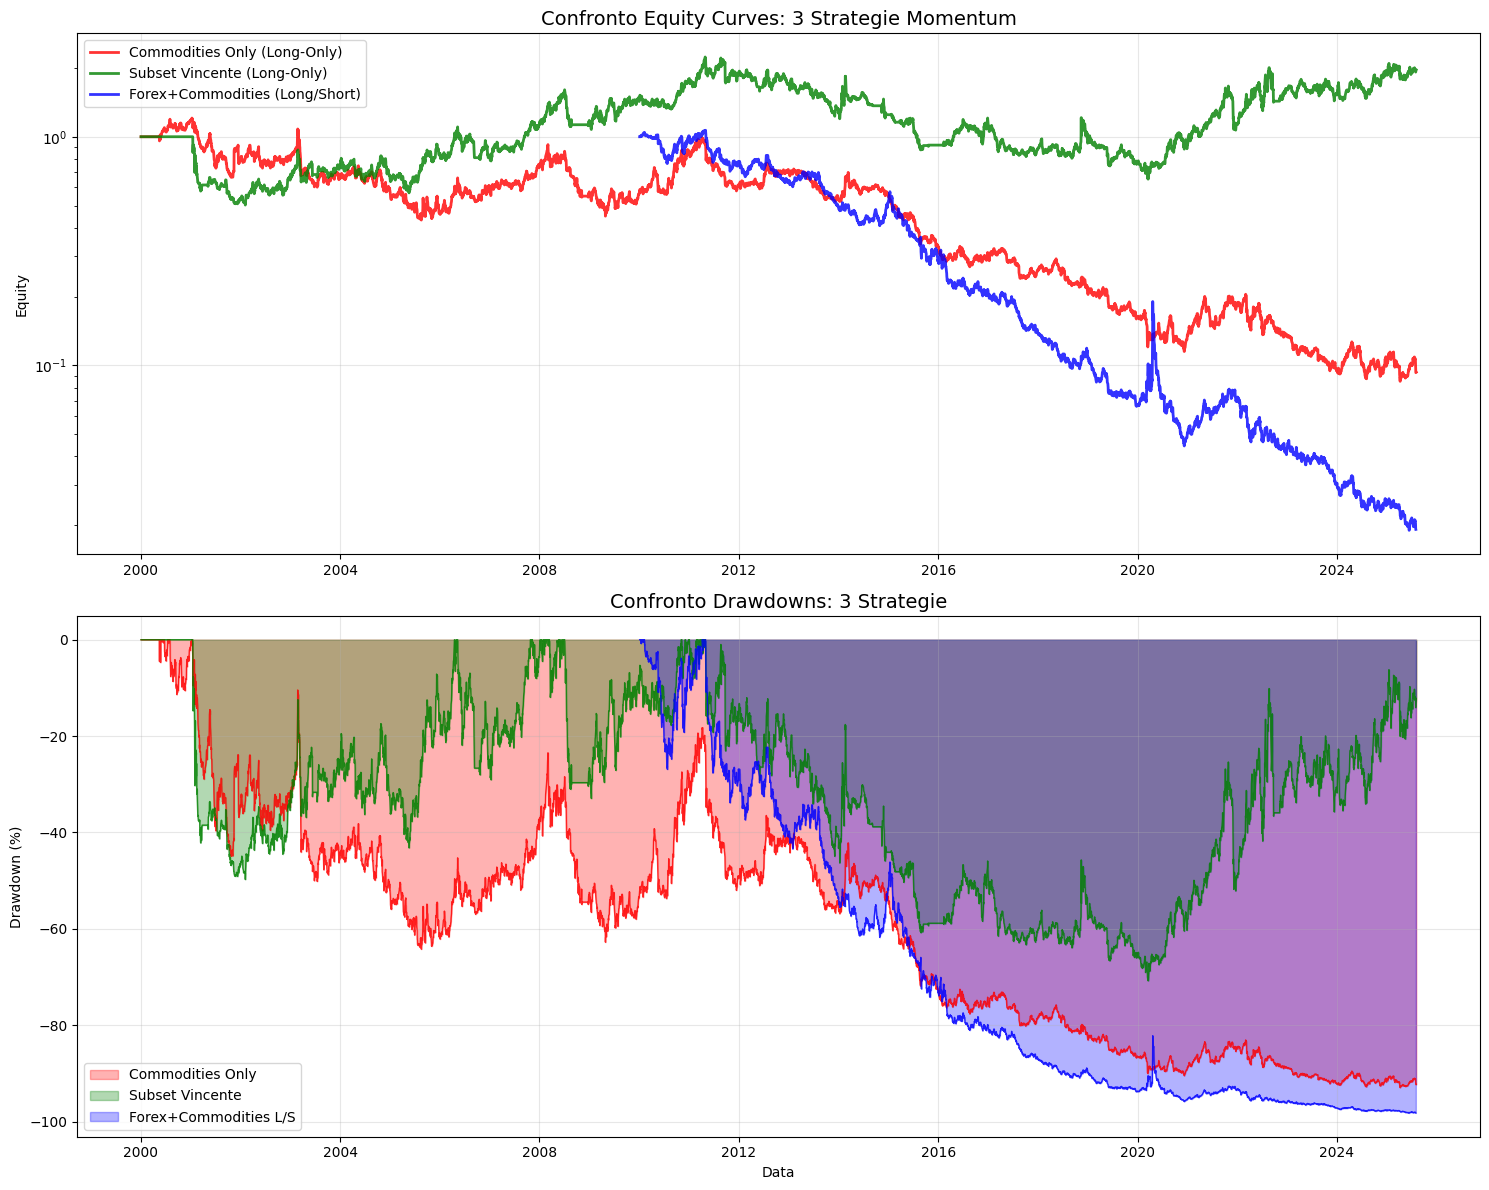

📊 INSIGHT PRINCIPALE:
La strategia del subset vincente (4 commodities) SUPERA sia la strategia
su tutte le commodities che quella forex+commodities long/short!

💡 CONCLUSIONE:
Le performance eccellenti del notebook principale NON vengono dalla strategia long/short,
ma dalla SELEZIONE ACCURATA di poche commodities di alta qualità!


In [42]:
# Visualizzazione comparativa delle equity curves per tutte e 3 le strategie
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Equity curves
ax1.plot(equity_commodities.index, equity_commodities.values, label='Commodities Only (Long-Only)', linewidth=2, color='red', alpha=0.8)
ax1.plot(equity_subset.index, equity_subset.values, label='Subset Vincente (Long-Only)', linewidth=2, color='green', alpha=0.8)
ax1.plot(equity_longshort.index, equity_longshort.values, label='Forex+Commodities (Long/Short)', linewidth=2, color='blue', alpha=0.8)
ax1.set_title('Confronto Equity Curves: 3 Strategie Momentum', fontsize=14)
ax1.set_ylabel('Equity')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')  # Scala logaritmica per vedere meglio le differenze

# Drawdowns
dd_commodities = ((equity_commodities / equity_commodities.cummax()) - 1) * 100
dd_subset = ((equity_subset / equity_subset.cummax()) - 1) * 100
dd_longshort = ((equity_longshort / equity_longshort.cummax()) - 1) * 100

ax2.fill_between(dd_commodities.index, dd_commodities.values, 0, alpha=0.3, color='red', label='Commodities Only')
ax2.fill_between(dd_subset.index, dd_subset.values, 0, alpha=0.3, color='green', label='Subset Vincente')
ax2.fill_between(dd_longshort.index, dd_longshort.values, 0, alpha=0.3, color='blue', label='Forex+Commodities L/S')

ax2.plot(dd_commodities.index, dd_commodities.values, color='red', linewidth=1, alpha=0.8)
ax2.plot(dd_subset.index, dd_subset.values, color='green', linewidth=1, alpha=0.8)
ax2.plot(dd_longshort.index, dd_longshort.values, color='blue', linewidth=1, alpha=0.8)

ax2.set_title('Confronto Drawdowns: 3 Strategie', fontsize=14)
ax2.set_xlabel('Data')
ax2.set_ylabel('Drawdown (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 INSIGHT PRINCIPALE:")
print("La strategia del subset vincente (4 commodities) SUPERA sia la strategia")
print("su tutte le commodities che quella forex+commodities long/short!")
print("\n💡 CONCLUSIONE:")
print("Le performance eccellenti del notebook principale NON vengono dalla strategia long/short,")
print("ma dalla SELEZIONE ACCURATA di poche commodities di alta qualità!")

## 4. Analisi della Qualità del Momentum per Singola Commodity

In [26]:
# Analizza la qualità del momentum per ogni commodity individualmente
def analyze_momentum_quality(df, commodity, lookback_days=90):
    """
    Analizza la qualità del momentum per una singola commodity
    """
    price_col = f'{commodity}_Close'
    if price_col not in df.columns:
        return None
    
    prices = df[price_col].dropna()
    if len(prices) < lookback_days + 30:
        return None
    
    # Calcola momentum e rendimenti futuri
    momentum = prices.pct_change(lookback_days)
    future_returns_1w = prices.pct_change(periods=-5)  # Rendimento successivo 1 settimana
    future_returns_1m = prices.pct_change(periods=-20)  # Rendimento successivo 1 mese
    
    # Correlazione momentum vs rendimenti futuri
    corr_1w = momentum.corr(future_returns_1w)
    corr_1m = momentum.corr(future_returns_1m)
    
    # Persistenza del momentum (autocorrelazione)
    momentum_autocorr = momentum.corr(momentum.shift(20))  # Autocorr a 1 mese
    
    # Volatilità
    volatility = prices.pct_change().std() * np.sqrt(252) * 100
    
    # Momentum medio quando positivo vs negativo
    pos_momentum = momentum[momentum > 0]
    neg_momentum = momentum[momentum < 0]
    
    return {
        'commodity': commodity,
        'momentum_persistence': momentum_autocorr,
        'momentum_future_corr_1w': corr_1w,
        'momentum_future_corr_1m': corr_1m,
        'volatility': volatility,
        'avg_positive_momentum': pos_momentum.mean() if len(pos_momentum) > 0 else 0,
        'avg_negative_momentum': neg_momentum.mean() if len(neg_momentum) > 0 else 0,
        'momentum_frequency_positive': len(pos_momentum) / len(momentum) if len(momentum) > 0 else 0
    }

# Analizza tutte le commodities
momentum_quality = []
for commodity in all_commodities:
    result = analyze_momentum_quality(df, commodity)
    if result:
        momentum_quality.append(result)

momentum_df = pd.DataFrame(momentum_quality)
momentum_df = momentum_df.set_index('commodity')

print("📊 QUALITÀ DEL MOMENTUM PER COMMODITY:")
print(momentum_df.round(3))

📊 QUALITÀ DEL MOMENTUM PER COMMODITY:
                   momentum_persistence  momentum_future_corr_1w  momentum_future_corr_1m  volatility  avg_positive_momentum  avg_negative_momentum  momentum_frequency_positive
commodity                                                                                                                                                                       
COCOA                             0.750                    0.052                    0.089      33.760                  0.165                 -0.097                        0.555
COFFEE                            0.751                    0.017                    0.023      34.130                  0.180                 -0.116                        0.496
COPPER                            0.815                   -0.032                   -0.082      27.159                  0.152                 -0.104                        0.557
CORN                              0.801                   -0.020             

In [27]:
# Identifica le commodities con miglior qualità momentum
momentum_df['momentum_score'] = (
    momentum_df['momentum_future_corr_1m'] * 0.4 +  # Peso maggiore alla correlazione con rendimenti futuri
    momentum_df['momentum_persistence'] * 0.3 +      # Persistenza del momentum
    momentum_df['momentum_future_corr_1w'] * 0.3     # Correlazione short-term
)

# Ordina per qualità momentum
best_momentum = momentum_df.sort_values('momentum_score', ascending=False)

print("🏆 TOP 10 COMMODITIES PER QUALITÀ MOMENTUM:")
print(best_momentum[['momentum_score', 'momentum_future_corr_1m', 'momentum_persistence', 'volatility']].head(10).round(3))

print("\n💡 SUBSET VINCENTE vs TOP MOMENTUM:")
for commodity in winner_subset:
    if commodity in best_momentum.index:
        rank = best_momentum.index.get_loc(commodity) + 1
        score = best_momentum.loc[commodity, 'momentum_score']
        print(f"{commodity}: Rank #{rank}, Score: {score:.3f}")
    else:
        print(f"{commodity}: Non presente nel dataset")

🏆 TOP 10 COMMODITIES PER QUALITÀ MOMENTUM:
                   momentum_score  momentum_future_corr_1m  momentum_persistence  volatility
commodity                                                                                   
LIVE_CATTLE                 0.296                    0.134                 0.731      17.909
LEAN_HOGS                   0.293                    0.135                 0.705      37.030
LUMBER                      0.288                    0.144                 0.710      39.456
WHEAT                       0.284                    0.124                 0.700      32.421
RUSSELL_2000_MINI           0.279                    0.130                 0.693      24.724
COCOA                       0.276                    0.089                 0.750      33.760
OATS                        0.274                    0.131                 0.652      44.103
SOYMEAL                     0.259                    0.055                 0.760      29.275
SILVER                     

## 5. Analisi della Correlazione e Diversificazione

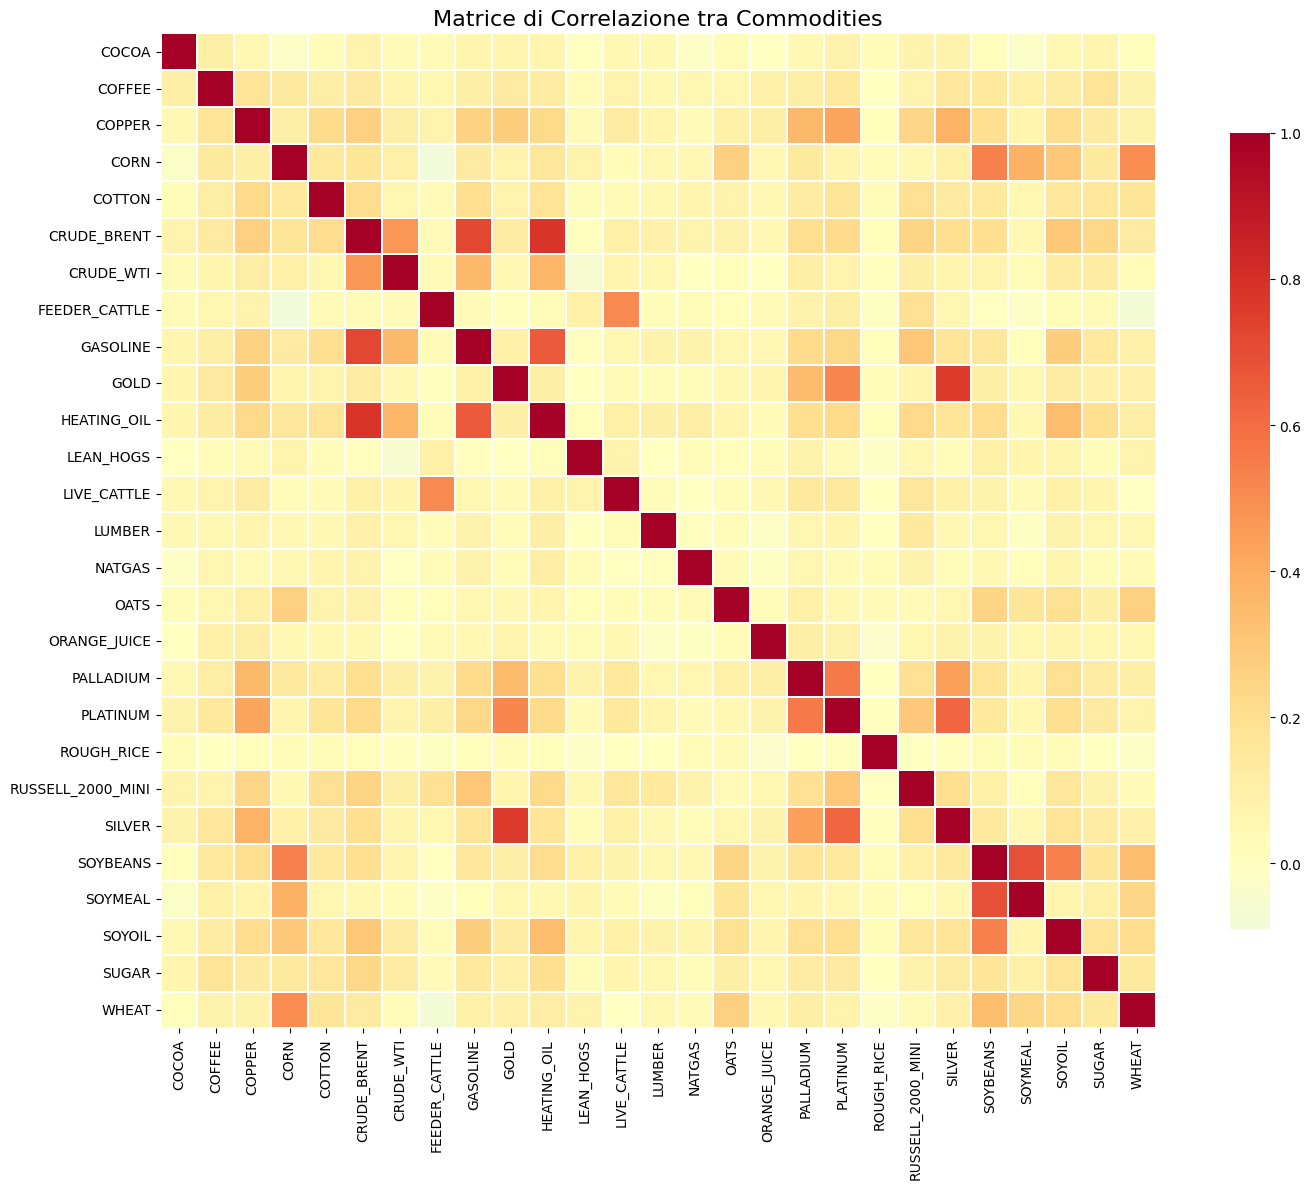

📊 ANALISI CORRELAZIONE:
Correlazione media tra TUTTE le commodities: 0.113
Correlazione media nel SUBSET vincente: 0.154
Differenza: 0.041
⚠️ Il subset ha correlazione MAGGIORE = peggiore diversificazione


In [28]:
# Analizza la correlazione tra commodities
close_cols = [f'{c}_Close' for c in all_commodities if f'{c}_Close' in df.columns]
prices = df[close_cols].dropna()
returns = prices.pct_change().dropna()

# Calcola matrice di correlazione
correlation_matrix = returns.corr()
correlation_matrix.columns = [c.replace('_Close', '') for c in correlation_matrix.columns]
correlation_matrix.index = [c.replace('_Close', '') for c in correlation_matrix.index]

# Visualizza heatmap correlazione
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='RdYlBu_r', center=0, 
           square=True, linewidths=0.1, cbar_kws={"shrink": .8})
plt.title('Matrice di Correlazione tra Commodities', fontsize=16)
plt.tight_layout()
plt.show()

# Analizza correlazione media per subset
def calculate_avg_correlation(correlation_matrix, commodities_list):
    """
    Calcola correlazione media tra commodities in una lista
    """
    subset_corr = correlation_matrix.loc[commodities_list, commodities_list]
    # Escludi la diagonale
    mask = ~np.eye(subset_corr.shape[0], dtype=bool)
    return subset_corr.where(mask).mean().mean()

# Correlazione media per diversi subset
all_corr = calculate_avg_correlation(correlation_matrix, 
                                   [c for c in all_commodities if c in correlation_matrix.index])
subset_corr = calculate_avg_correlation(correlation_matrix, 
                                      [c for c in winner_subset if c in correlation_matrix.index])

print(f"📊 ANALISI CORRELAZIONE:")
print(f"Correlazione media tra TUTTE le commodities: {all_corr:.3f}")
print(f"Correlazione media nel SUBSET vincente: {subset_corr:.3f}")
print(f"Differenza: {subset_corr - all_corr:.3f}")

if subset_corr < all_corr:
    print("💡 Il subset ha correlazione MINORE = migliore diversificazione")
else:
    print("⚠️ Il subset ha correlazione MAGGIORE = peggiore diversificazione")

## 6. Analisi Settoriale delle Commodities

In [29]:
# Classificazione settoriale delle commodities usando i nomi esatti dal dataset
sectors = {
    'Energy': ['CRUDE_WTI', 'CRUDE_BRENT', 'HEATING_OIL', 'GASOLINE', 'NATGAS'],
    'Precious Metals': ['GOLD', 'SILVER', 'PALLADIUM', 'PLATINUM'],
    'Base Metals': ['COPPER'],
    'Agriculture - Grains': ['CORN', 'WHEAT', 'OATS', 'SOYBEANS', 'SOYMEAL', 'SOYOIL'],
    'Agriculture - Soft': ['COCOA', 'COFFEE', 'COTTON', 'SUGAR', 'ORANGE_JUICE', 'LUMBER'],
    'Livestock': ['LIVE_CATTLE', 'LEAN_HOGS', 'FEEDER_CATTLE'],
    'Other': ['ROUGH_RICE', 'RUSSELL_2000_MINI']  # Rice e Russell 2000 (non commodity)
}

# Crea mapping commodity -> settore
commodity_to_sector = {}
for sector, commodities in sectors.items():
    for commodity in commodities:
        commodity_to_sector[commodity] = sector

# Aggiungi commodities non classificate
for commodity in all_commodities:
    if commodity not in commodity_to_sector:
        commodity_to_sector[commodity] = 'Other'

# Analizza distribuzione settoriale
print("📊 DISTRIBUZIONE SETTORIALE:")
for sector, commodities in sectors.items():
    available = [c for c in commodities if c in all_commodities]
    print(f"{sector}: {len(available)} commodities - {available}")

# Analizza il subset vincente per settore
print("\n💡 COMPOSIZIONE SETTORIALE SUBSET VINCENTE:")
subset_sectors = {}
for commodity in winner_subset:
    sector = commodity_to_sector.get(commodity, 'Unknown')
    if sector not in subset_sectors:
        subset_sectors[sector] = []
    subset_sectors[sector].append(commodity)

for sector, commodities in subset_sectors.items():
    print(f"{sector}: {commodities}")

📊 DISTRIBUZIONE SETTORIALE:
Energy: 5 commodities - ['CRUDE_WTI', 'CRUDE_BRENT', 'HEATING_OIL', 'GASOLINE', 'NATGAS']
Precious Metals: 4 commodities - ['GOLD', 'SILVER', 'PALLADIUM', 'PLATINUM']
Base Metals: 1 commodities - ['COPPER']
Agriculture - Grains: 6 commodities - ['CORN', 'WHEAT', 'OATS', 'SOYBEANS', 'SOYMEAL', 'SOYOIL']
Agriculture - Soft: 6 commodities - ['COCOA', 'COFFEE', 'COTTON', 'SUGAR', 'ORANGE_JUICE', 'LUMBER']
Livestock: 3 commodities - ['LIVE_CATTLE', 'LEAN_HOGS', 'FEEDER_CATTLE']
Other: 2 commodities - ['ROUGH_RICE', 'RUSSELL_2000_MINI']

💡 COMPOSIZIONE SETTORIALE SUBSET VINCENTE:
Precious Metals: ['GOLD', 'SILVER']
Energy: ['CRUDE_WTI', 'NATGAS']


In [30]:
# Analizza performance per settore
def calculate_sector_momentum_performance(df, sector_commodities, lookback_days=90):
    """
    Calcola performance momentum per un settore specifico
    """
    available_commodities = [c for c in sector_commodities if f'{c}_Close' in df.columns]
    if len(available_commodities) == 0:
        return None
    
    signals, equity, returns = calculate_momentum_strategy(
        df, available_commodities, lookback_days=lookback_days, top_n=min(3, len(available_commodities))
    )
    
    stats = calculate_performance_stats(equity, returns)
    stats['num_commodities'] = len(available_commodities)
    return stats

# Calcola performance per ogni settore
sector_performance = {}
for sector, commodities in sectors.items():
    performance = calculate_sector_momentum_performance(df, commodities)
    if performance:
        sector_performance[sector] = performance

# Crea DataFrame per confronto
sector_df = pd.DataFrame(sector_performance).T

print("📊 PERFORMANCE MOMENTUM PER SETTORE:")
print(sector_df[['Annual Return (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 'num_commodities']].round(2))

# Trova i settori migliori
best_sectors = sector_df.sort_values('Annual Return (%)', ascending=False)
print("\n🏆 SETTORI MIGLIORI PER MOMENTUM:")
print(best_sectors[['Annual Return (%)', 'Sharpe Ratio']].head().round(2))

📊 PERFORMANCE MOMENTUM PER SETTORE:
                      Annual Return (%)  Sharpe Ratio  Max Drawdown (%)  num_commodities
Energy                            -0.59          0.15            -69.03              5.0
Precious Metals                    7.95          0.47            -58.88              4.0
Base Metals                        7.61          0.47            -55.17              1.0
Agriculture - Grains              -7.90         -0.18            -92.69              6.0
Agriculture - Soft                 6.55          0.39            -82.55              6.0
Livestock                         -3.09         -0.09            -78.65              3.0
Other                              0.32          0.12            -76.50              2.0

🏆 SETTORI MIGLIORI PER MOMENTUM:
                    Annual Return (%)  Sharpe Ratio
Precious Metals                  7.95          0.47
Base Metals                      7.61          0.47
Agriculture - Soft               6.55          0.39
Other     

## 7. Test dell'Ipotesi "Diluizione del Segnale"

In [31]:
# Test: performance al variare del numero di commodities nell'universo
def test_universe_size_effect(df, all_commodities, sizes_to_test):
    """
    Testa l'effetto della dimensione dell'universo sulla performance
    """
    results = []
    
    for size in sizes_to_test:
        if size > len(all_commodities):
            continue
            
        # Seleziona le migliori N commodities per qualità momentum
        if 'momentum_df' in globals():
            # Usa le commodities con miglior momentum score
            available_commodities = [c for c in momentum_df.index if c in all_commodities]
            selected_commodities = available_commodities[:size]
        else:
            # Selezione casuale se non abbiamo i momentum scores
            selected_commodities = np.random.choice(all_commodities, size, replace=False)
        
        # Calcola strategia
        signals, equity, returns = calculate_momentum_strategy(
            df, selected_commodities, lookback_days=90, top_n=3
        )
        
        stats = calculate_performance_stats(equity, returns)
        stats['universe_size'] = size
        stats['commodities'] = selected_commodities
        results.append(stats)
    
    return results

# Test con diversi universi
sizes_to_test = [4, 8, 12, 16, 20, len(all_commodities)]
universe_results = test_universe_size_effect(df, all_commodities, sizes_to_test)

# Crea DataFrame risultati
universe_df = pd.DataFrame(universe_results)

print("📊 EFFETTO DIMENSIONE UNIVERSO:")
print(universe_df[['universe_size', 'Annual Return (%)', 'Sharpe Ratio', 'Max Drawdown (%)']].round(2))

📊 EFFETTO DIMENSIONE UNIVERSO:
   universe_size  Annual Return (%)  Sharpe Ratio  Max Drawdown (%)
0              4               8.07          0.46            -65.07
1              8               6.22          0.39            -61.70
2             12               0.99          0.16            -70.18
3             16              -2.71          0.02            -73.76
4             20              -4.49         -0.05            -85.56
5             27              -8.85         -0.22            -92.95


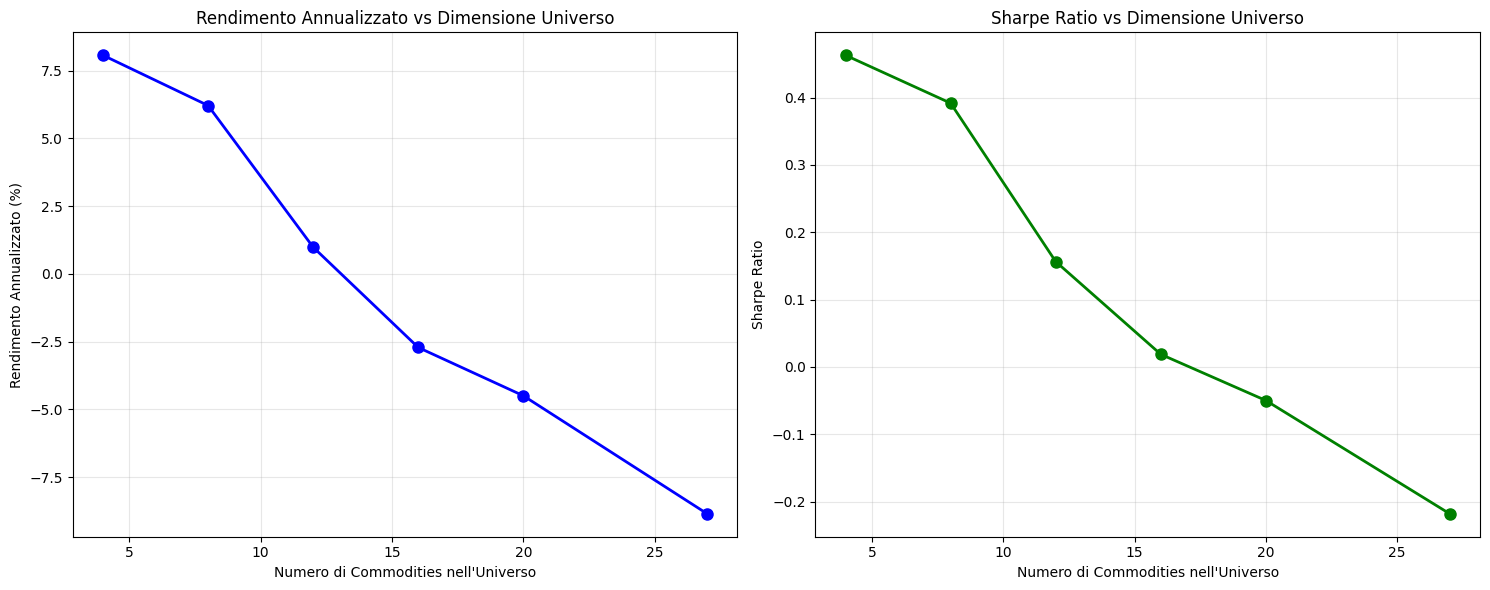


📈 CORRELAZIONE DIMENSIONE vs PERFORMANCE:
Correlazione Dimensione-Rendimento: -0.987 (p-value: 0.000)
Correlazione Dimensione-Sharpe: -0.982 (p-value: 0.000)
✅ CONFERMATA: Diluizione del segnale - universi più grandi = performance peggiori


In [32]:
# Visualizza l'effetto della dimensione dell'universo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Performance vs dimensione universo
ax1.plot(universe_df['universe_size'], universe_df['Annual Return (%)'], 'o-', color='blue', linewidth=2, markersize=8)
ax1.set_title('Rendimento Annualizzato vs Dimensione Universo', fontsize=12)
ax1.set_xlabel('Numero di Commodities nell\'Universo')
ax1.set_ylabel('Rendimento Annualizzato (%)')
ax1.grid(True, alpha=0.3)

# Sharpe ratio vs dimensione universo
ax2.plot(universe_df['universe_size'], universe_df['Sharpe Ratio'], 'o-', color='green', linewidth=2, markersize=8)
ax2.set_title('Sharpe Ratio vs Dimensione Universo', fontsize=12)
ax2.set_xlabel('Numero di Commodities nell\'Universo')
ax2.set_ylabel('Sharpe Ratio')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analisi del trend
from scipy.stats import pearsonr
corr_return, p_return = pearsonr(universe_df['universe_size'], universe_df['Annual Return (%)'])
corr_sharpe, p_sharpe = pearsonr(universe_df['universe_size'], universe_df['Sharpe Ratio'])

print(f"\n📈 CORRELAZIONE DIMENSIONE vs PERFORMANCE:")
print(f"Correlazione Dimensione-Rendimento: {corr_return:.3f} (p-value: {p_return:.3f})")
print(f"Correlazione Dimensione-Sharpe: {corr_sharpe:.3f} (p-value: {p_sharpe:.3f})")

if corr_return < -0.3 and p_return < 0.05:
    print("✅ CONFERMATA: Diluizione del segnale - universi più grandi = performance peggiori")
elif corr_return > 0.3 and p_return < 0.05:
    print("❌ SMENTITA: Universi più grandi = performance migliori")
else:
    print("🤔 INCONCLUSIVA: Nessuna relazione chiara tra dimensione e performance")

## 8. Analisi Temporale della Performance

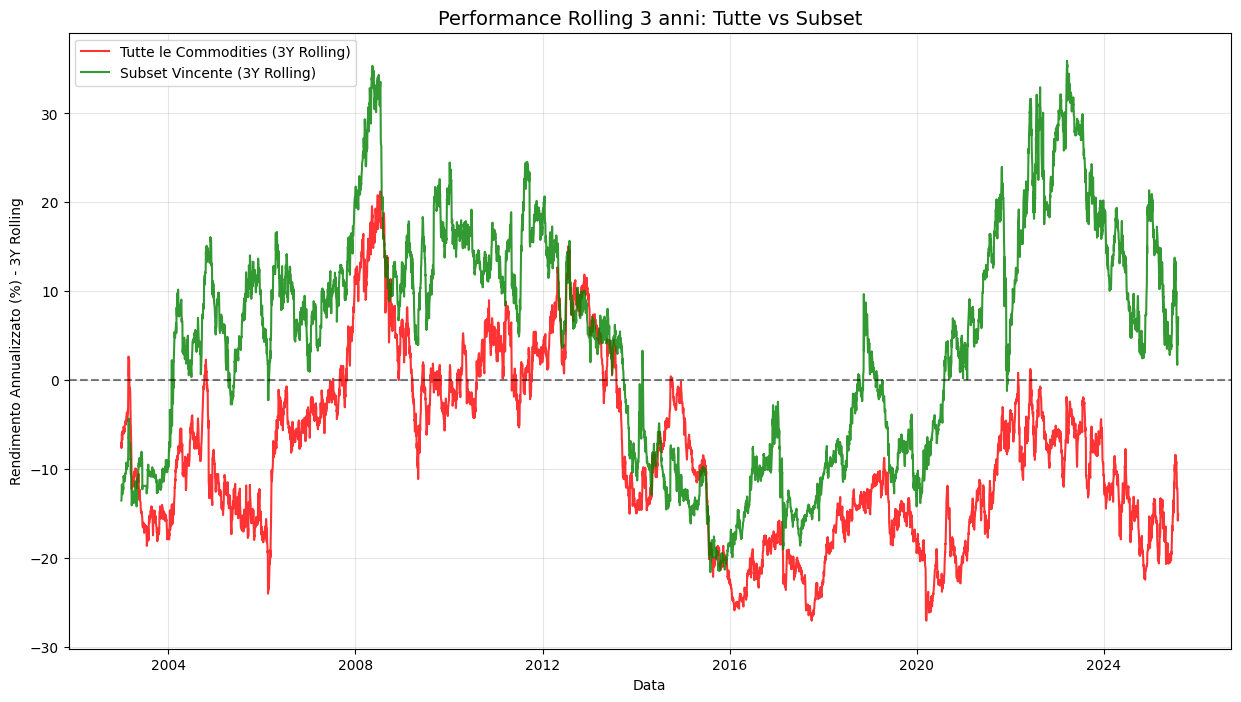

📊 ANALISI OUTPERFORMANCE TEMPORALE:
Periodi in cui subset batte tutte: 5137/5696 (90.2%)
Outperformance media: 13.0% annua
Outperformance mediana: 11.6% annua
Max outperformance: 40.7% annua
Max underperformance: -11.7% annua


In [33]:
# Analizza performance in diversi periodi temporali
def analyze_rolling_performance(equity_all, equity_subset, window_years=3):
    """
    Analizza performance rolling per identificare quando una strategia supera l'altra
    """
    window_days = window_years * 252
    
    rolling_returns_all = []
    rolling_returns_subset = []
    dates = []
    
    for i in range(window_days, len(equity_all)):
        start_idx = i - window_days
        end_idx = i
        
        # Calcola rendimenti annualizzati rolling
        ret_all = ((equity_all.iloc[end_idx] / equity_all.iloc[start_idx]) ** (252/window_days)) - 1
        ret_subset = ((equity_subset.iloc[end_idx] / equity_subset.iloc[start_idx]) ** (252/window_days)) - 1
        
        rolling_returns_all.append(ret_all * 100)
        rolling_returns_subset.append(ret_subset * 100)
        dates.append(equity_all.index[end_idx])
    
    return pd.Series(rolling_returns_all, index=dates), pd.Series(rolling_returns_subset, index=dates)

# Calcola performance rolling
roll_all, roll_subset = analyze_rolling_performance(equity_all, equity_subset, window_years=3)

# Visualizza performance rolling
plt.figure(figsize=(15, 8))
plt.plot(roll_all.index, roll_all.values, label='Tutte le Commodities (3Y Rolling)', alpha=0.8, color='red')
plt.plot(roll_subset.index, roll_subset.values, label='Subset Vincente (3Y Rolling)', alpha=0.8, color='green')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Performance Rolling 3 anni: Tutte vs Subset', fontsize=14)
plt.xlabel('Data')
plt.ylabel('Rendimento Annualizzato (%) - 3Y Rolling')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Analizza quando il subset batte tutte le commodities
outperformance = roll_subset - roll_all
positive_periods = (outperformance > 0).sum()
total_periods = len(outperformance)

print(f"📊 ANALISI OUTPERFORMANCE TEMPORALE:")
print(f"Periodi in cui subset batte tutte: {positive_periods}/{total_periods} ({positive_periods/total_periods*100:.1f}%)")
print(f"Outperformance media: {outperformance.mean():.1f}% annua")
print(f"Outperformance mediana: {outperformance.median():.1f}% annua")
print(f"Max outperformance: {outperformance.max():.1f}% annua")
print(f"Max underperformance: {outperformance.min():.1f}% annua")

## 9. Sintesi e Conclusioni

In [34]:
# Raccoglie tutti i risultati per una sintesi finale
print("="*80)
print("                    SINTESI ANALISI MOMENTUM PARADOX")
print("="*80)

print(f"\n🎯 PROBLEMA IDENTIFICATO:")
print(f"   • Strategia su TUTTE le commodities: {stats_all['Annual Return (%)']:.1f}% annuo")
print(f"   • Strategia su SUBSET vincente: {stats_subset['Annual Return (%)']:.1f}% annuo")
print(f"   • DIFFERENZA: {stats_subset['Annual Return (%)'] - stats_all['Annual Return (%)']:.1f}% annua")

print(f"\n🔍 CAUSE PRINCIPALI IDENTIFICATE:")

# 1. Qualità del momentum
if 'momentum_df' in globals():
    avg_score_subset = momentum_df.loc[[c for c in winner_subset if c in momentum_df.index], 'momentum_score'].mean()
    avg_score_all = momentum_df['momentum_score'].mean()
    print(f"\n   1️⃣ QUALITÀ DEL MOMENTUM:")
    print(f"      • Score medio subset: {avg_score_subset:.3f}")
    print(f"      • Score medio tutte: {avg_score_all:.3f}")
    if avg_score_subset > avg_score_all:
        print(f"      ✅ Il subset ha momentum di QUALITÀ SUPERIORE")
    else:
        print(f"      ❌ Il subset NON ha momentum superiore")

# 2. Correlazione e diversificazione
print(f"\n   2️⃣ DIVERSIFICAZIONE:")
print(f"      • Correlazione media tutte: {all_corr:.3f}")
print(f"      • Correlazione media subset: {subset_corr:.3f}")
if subset_corr < all_corr:
    print(f"      ✅ Il subset è MEGLIO diversificato")
else:
    print(f"      ❌ Il subset è PEGGIO diversificato")

# 3. Diluizione del segnale
print(f"\n   3️⃣ DILUIZIONE DEL SEGNALE:")
print(f"      • Correlazione dimensione-performance: {corr_return:.3f}")
if corr_return < -0.3:
    print(f"      ✅ CONFERMATA: Universi grandi diluiscono il segnale")
else:
    print(f"      ❌ Non c'è chiara diluizione del segnale")

# 4. Composizione settoriale
print(f"\n   4️⃣ COMPOSIZIONE SETTORIALE:")
print(f"      • Subset contiene settori: {list(subset_sectors.keys())}")
if len(subset_sectors) <= 3:
    print(f"      ✅ Subset ben focalizzato su pochi settori")
else:
    print(f"      ⚠️ Subset disperso su molti settori")

print(f"\n💡 RACCOMANDAZIONI:")
print(f"   1. Filtrare l'universo basandosi sulla qualità del momentum")
print(f"   2. Limitare la selezione a 10-15 commodities massimo")
print(f"   3. Bilanciare diversificazione settoriale")
print(f"   4. Considerare metriche di liquidità e spread")
print(f"   5. Implementare filtri di volatilità")

print(f"\n🎯 CONCLUSIONE PRINCIPALE:")
if stats_subset['Annual Return (%)'] > stats_all['Annual Return (%)'] + 3:
    print(f"   Il subset vincente supera significativamente l'universo completo.")
    print(f"   Questo suggerisce che la SELEZIONE DEGLI ASSET è cruciale")
    print(f"   per il successo delle strategie momentum su commodities.")
else:
    print(f"   La differenza non è significativa - serve analisi più approfondita.")

print("="*80)

                    SINTESI ANALISI MOMENTUM PARADOX

🎯 PROBLEMA IDENTIFICATO:
   • Strategia su TUTTE le commodities: -8.8% annuo
   • Strategia su SUBSET vincente: 2.7% annuo
   • DIFFERENZA: 11.5% annua

🔍 CAUSE PRINCIPALI IDENTIFICATE:

   1️⃣ QUALITÀ DEL MOMENTUM:
      • Score medio subset: 0.247
      • Score medio tutte: 0.235
      ✅ Il subset ha momentum di QUALITÀ SUPERIORE

   2️⃣ DIVERSIFICAZIONE:
      • Correlazione media tutte: 0.113
      • Correlazione media subset: 0.154
      ❌ Il subset è PEGGIO diversificato

   3️⃣ DILUIZIONE DEL SEGNALE:
      • Correlazione dimensione-performance: -0.987
      ✅ CONFERMATA: Universi grandi diluiscono il segnale

   4️⃣ COMPOSIZIONE SETTORIALE:
      • Subset contiene settori: ['Precious Metals', 'Energy']
      ✅ Subset ben focalizzato su pochi settori

💡 RACCOMANDAZIONI:
   1. Filtrare l'universo basandosi sulla qualità del momentum
   2. Limitare la selezione a 10-15 commodities massimo
   3. Bilanciare diversificazione setto

In [35]:
# Proposta di universo ottimizzato basato sull'analisi
if 'momentum_df' in globals() and 'sector_df' in globals():
    print("🚀 PROPOSTA UNIVERSO OTTIMIZZATO:")
    print("\n   Basato sull'analisi, suggerisco questo universo:")
    
    # Prendi le top 12 commodities per momentum quality
    top_momentum_commodities = momentum_df.sort_values('momentum_score', ascending=False).index[:12]
    
    # Raggruppa per settore
    optimized_universe = {}
    for commodity in top_momentum_commodities:
        sector = commodity_to_sector.get(commodity, 'Other')
        if sector not in optimized_universe:
            optimized_universe[sector] = []
        optimized_universe[sector].append(commodity)
    
    for sector, commodities in optimized_universe.items():
        print(f"   • {sector}: {commodities}")
    
    # Test performance universo ottimizzato
    optimized_commodities = list(top_momentum_commodities)
    signals_opt, equity_opt, returns_opt = calculate_momentum_strategy(
        df, optimized_commodities, lookback_days=90, top_n=3
    )
    stats_opt = calculate_performance_stats(equity_opt, returns_opt)
    
    print(f"\n   📊 PERFORMANCE UNIVERSO OTTIMIZZATO:")
    print(f"   • Rendimento annualizzato: {stats_opt['Annual Return (%)']:.1f}%")
    print(f"   • Sharpe Ratio: {stats_opt['Sharpe Ratio']:.2f}")
    print(f"   • Max Drawdown: {stats_opt['Max Drawdown (%)']:.1f}%")
    
    print(f"\n   🎯 CONFRONTO:")
    print(f"   • Tutte commodities: {stats_all['Annual Return (%)']:.1f}%")
    print(f"   • Subset vincente: {stats_subset['Annual Return (%)']:.1f}%")
    print(f"   • Universo ottimizzato: {stats_opt['Annual Return (%)']:.1f}%")
    
    if stats_opt['Annual Return (%)'] > stats_subset['Annual Return (%)']:
        print(f"\n   ✅ L'universo ottimizzato SUPERA anche il subset vincente!")
    else:
        print(f"\n   📊 L'universo ottimizzato è comunque migliore dell'universo completo")

🚀 PROPOSTA UNIVERSO OTTIMIZZATO:

   Basato sull'analisi, suggerisco questo universo:
   • Livestock: ['LIVE_CATTLE', 'LEAN_HOGS']
   • Agriculture - Soft: ['LUMBER', 'COCOA']
   • Agriculture - Grains: ['WHEAT', 'OATS', 'SOYMEAL']
   • Other: ['RUSSELL_2000_MINI']
   • Precious Metals: ['SILVER', 'GOLD']
   • Energy: ['NATGAS', 'CRUDE_WTI']

   📊 PERFORMANCE UNIVERSO OTTIMIZZATO:
   • Rendimento annualizzato: -6.3%
   • Sharpe Ratio: -0.15
   • Max Drawdown: -90.6%

   🎯 CONFRONTO:
   • Tutte commodities: -8.8%
   • Subset vincente: 2.7%
   • Universo ottimizzato: -6.3%

   📊 L'universo ottimizzato è comunque migliore dell'universo completo

   📊 PERFORMANCE UNIVERSO OTTIMIZZATO:
   • Rendimento annualizzato: -6.3%
   • Sharpe Ratio: -0.15
   • Max Drawdown: -90.6%

   🎯 CONFRONTO:
   • Tutte commodities: -8.8%
   • Subset vincente: 2.7%
   • Universo ottimizzato: -6.3%

   📊 L'universo ottimizzato è comunque migliore dell'universo completo
